# Logistic regression I: MNIST

In this notebook, you will implement a logistic regression and train it to distinguish between two types of digits of the MNIST dataset.

First, the standard imports:

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import torch as th
from torchvision.datasets import MNIST
from torchvision.utils import make_grid

from sklearn import metrics

plt.rcParams["figure.figsize"] = (9, 6)

## Dataset loading

We will use the MNIST dataset available in `torchvision`:

In [3]:
mnist_train = MNIST("./datasets", train=True, download=True)
mnist_test = MNIST("./datasets", train=False)

The training dataset is made of 60k images of $28\times{}28$ pixels. The test set contains 10k images.

In [4]:
mnist_train.data.shape, mnist_test.data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

As we did in the previous assignment, we vectorize all the images (concatenating their pixels in a sigle row) and consider that they are elements of the Euclidean space $\mathbb{R}^{784}$. Also, we extract their target values.

In [20]:
data_train = th.reshape(mnist_train.data, (-1, 28**2))
data_test = th.reshape(mnist_test.data, (-1, 28**2))

target_train = mnist_train.targets
target_test = mnist_test.targets

print(data_train.shape, data_test.shape)

torch.Size([60000, 784]) torch.Size([10000, 784])


## Data preprocessing

As we saw in the first week, in classical computer vision problems it was necessary to compute relevant features from the images before feeding them to a machine learning model. This had two main goals: first, to reduce the dimensionality of the input space to prevent the _curse of dimensionality_; second, to reduce the variance of the model by making it robust to fluctuations of the input data that are not related to the variable of interest (for example, noise). For the MNIST dataset we could extract features such as the width of the digit, the proportion of white pixels in the image, the distribution of vertical/horizontal/diagonal segments or the number of black connected components (i.e., the number of holes of the digit). As we saw, the downside of feature extraction is that it is problem-dependent and requires a considerable amount of human effort.

Instead of designing a method for feature extraction, in this assignment we will follow the modern deep learning approach and feed the logistic classifier with raw pixel values (logistic regression is a simple neural network, after all). However, as we saw in class, this is not completely straighforward: the gradients of logistic regression are very small when the weights and the input values are not scaled properly, leading to extremely slow training progression. Therefore, you should ensure that the pixel values you will feed to the classifier have an appropriate range, avoiding very large values.

### <font color='orange'>Question 1</font>

Check the range of the image data and rescale it to the range (0, 1) if it is necessary. Apply the same transformation to both the training and test data. Save the results in the variables `data_train` and `data_test`.

There are several options to do this: you can divide by the largest value allowed by the data type of the datasets (the easiest approach), or you can divide by the largest value that is present in the training dataset.

Note that if your transformation depends on a value computed over a dataset (for example, the maximum value of the dataset), you MUST compute that value using only the training dataset. Otherwise, you might be leaking information from the test set to the training procedure.

In [21]:
max_TrainVal = data_train.max() #255
data_train = data_train/max_TrainVal
data_test = data_test/max_TrainVal


___

### <font color='orange'>Question 2</font>

Logistic regression is a binary classifier, but MNIST has 10 classes. We will follow a one-vs-rest approach and build a model that distinguishes one digit vs. the rest. Pick one digit and set it to the variables `class1`. This digit will get the label 1, while the rest of digits will get the label 0.

Build the target variables `target01_train` and `target01_test` with binary values 1 and 0 indicating whether the corresponding digit is `class1` or not. That is, `target01_train` should be 1 where `target_train` is `class1`, and `data_train[target01_train == 1]` should return all the samples of the `class1`.

Visualize a few samples of each class (you can use `torchvision.utils.make_grid` for this, or plot the samples manually). Show at least 9 samples with `target01_train==0` and 9 samples with `target01_train==1`. Note that you will need `torch.reshape` and perhaps `torch.permute` to provide `plt.imshow` a proper shape it can work with.

In [45]:
class1 = 6  # Change this to the digit you want to use as class 1. The rest of the digits will be class 0.

# Create the target variables target01_train and target01_test according to the value of class1.
v = th.tensor([1,6,7])
v01 = (v==class1).type(th.uint8)
print(v01)

target01_train = (target_train==class1).type(th.uint8)
target01_test = (target_test==class1).type(th.uint8)

data_train[target01_train == 1].shape


tensor([0, 1, 0], dtype=torch.uint8)


torch.Size([5918, 784])

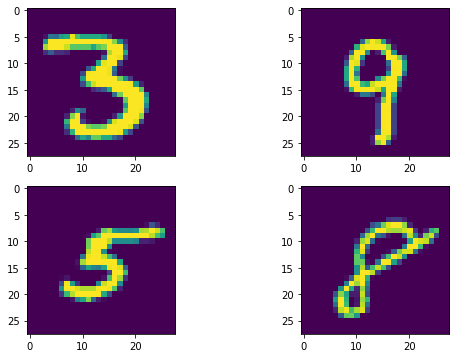

In [46]:
# Plot some samples of class 0 
class0_images = data_train[target01_train != 1]

img1 = class0_images[12].reshape((28,28))
img2 = class0_images[145].reshape((28,28))
img3 = class0_images[5000].reshape((28,28))
img4 = class0_images[-1].reshape((28,28))

fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(img1)
axs[0, 1].imshow(img2)
axs[1, 0].imshow(img3)
axs[1, 1].imshow(img4)









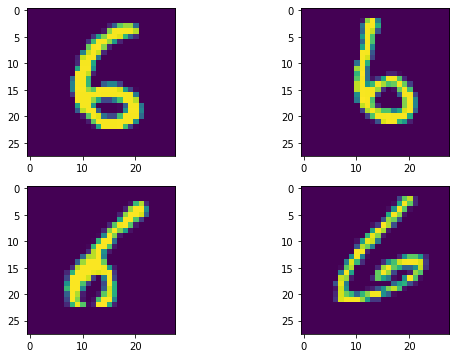

In [47]:
# Plot some samples of class 1

class1_images = data_train[target01_train == 1]

img1 = class1_images[12].reshape((28,28))
img2 = class1_images[145].reshape((28,28))
img3 = class1_images[5000].reshape((28,28))
img4 = class1_images[-1].reshape((28,28))

fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(img1)
axs[0, 1].imshow(img2)
axs[1, 0].imshow(img3)
axs[1, 1].imshow(img4)

___

## Logistic regression

Remember that logistic regression consists of a linear (actually, affine) transformation of the input vector `x` with the weights `w` and a bias `b`, followed by the logistic function that shrinks the output range to the range (0, 1),
$$f(\mathbf{x};\mathbf{w}, b) = \sigma(\mathbf{x}^T\cdot\mathbf{w} + b).$$

This equation is expressed for a single input sample $\mathbf{x}$, but in practical implementatios with PyTorch it is necessary that our models are able to process multiple elements simultaneously using tensor operations. The goal of the next exercise is to implement the logistic regression model in such a way that it can deal simultaneously with many input samples, and not just with one.

### <font color='orange'>Question 3</font>

Implement a function `logistic_regression` that receives an input tensor `x` with shape `(num_samples, num_dims)`, a tensor `weights` with shape `(num_dims,)`, a scalar tensor `bias`, and returns the output of the logistic regression with shape `(num_samples,)` for all the elements of `x`.

Hint: use the `@` operator to deal with `x` and `weights`.

Hint: you can use `torch.sigmoid` to apply the logistic function or you can implement it manually.


In [48]:
def logistic_regression (x: th.tensor, weights: th.tensor, bias) -> th.tensor:
    bias = bias[0:x.shape[0]]
    return th.sigmoid(x@weights+bias)

x = th.randn(6,10)
w = th.randn(10,1)
b = th.zeros(6,1)

test = logistic_regression(x,w,b)

test.shape




torch.Size([6, 1])

___

As we discussed in class, the output of the logistic regression is interpreted as the probability parameter $\hat{p}=f(\mathbf{x};\mathbf{w}, b)$ of a Bernoulli distribution:
$$p(y\mid \hat{p})=\cases{1-\hat{p} & if y=0\\ \hat{p} & if y=1}.$$

The cross-entropy loss is the $-\log$ of the probability of the correct answer:
$$ \ell(y, \hat{p}) = -\log p(y\mid \hat{p}) = \cases{-\log 1-\hat{p} & if y=0\\ -\log \hat{p} & if y=1}.$$

As above, the implementation of the loss function needs to deal with multiple elements simultaneously for efficiency.


Implement the function `binary_cross_entropy` that receives the tensor `p_hat` of shape `(num_samples,)` and type `float` containing the predictions from the logistic regression, and the tensor `y` of the same shape and type `int` containing the correct answer for each element, and computes the **mean** of the cross-entropy losses across all the elements.

Hint: use `torch.where` to select between $-\log \hat{p}$ and $-\log (1-\hat{p})$ according to `y`.

In [49]:
def binary_cross_entropy(p_hat: th.tensor, y : th.tensor) ->th.tensor:
    case1 = -th.log(1-p_hat)
    case2 = -th.log(p_hat)
    return th.where(y==0,case1,case2)

y = th.tensor([1,0,1,0,1])
c1 = th.ones(y.shape)
c2 = th.zeros(y.shape)
z = th.where(y==0,c1,c2)

target01_train.shape
y.shape

torch.Size([5])

___

## Training with gradient descent

### <font color='orange'>Question 5</font>

Write code to minimize the loss
$$\min_{\mathbf{w}, b} \sum_i \ell(y^{(i)}, f(\mathbf{x}^{(i)}; \mathbf{w}, b))$$
using gradient descent. The training set should be `data_train` with the labels `target01_train` that you created in Question 2.

This code should

1. Create the tensors of weights and bias with the proper shapes. The initialization of parameters is not a simple topic and we will look at it in more depth in a future class. For now, initializate the weights with random Gaussian values (use `torch.randn`) divided by the number of dimensions (i.e., `th.randn(...) / 784`), and initialize the bias to 0.
2. Enable the gradient computation for these two tensors calling `.requires_grad_()`.
3. Set a learning rate $\eta$.
4. Initialize an empty list `losses` to store intermediate losses and plot them later.
5. Repeat `num_iterations` times:
    1. Compute the loss for the entire training data.
    2. Compute the gradients calling `.backward()` in the loss tensor.
    3. Update the weights and the bias with the computed gradients using the gradient descent update rule. Remember to do so in a `torch.no_grad()` context and set the gradients `.grad` to `None` after the update.
    4. Store the loss into `losses`. Remember to call `.detach()` to store just the value of the tensor and not the computational graph.
    5. You might want to set a stopping criterion that ends training when the changes to the training loss are below a threshold (e.g., `th.abs(losses[-1] - losses[-2]) < 1e-8`), but this is optional.
6. Plot `losses` and check whether/how the training loss decreased during training.

You might need to try a few values for the learning rate $\eta$ and the number of iterations so that the evolution of the training loss looks smooth and converges to an almost constant value. Changes to the learning rate are significant in a logarithmic scale (e.g., $10^{-4}, 10^{-3}, 10^{-2}, 10^{-1}, 10^0, \ldots$), not in a linear scale (e.g., $0.1, 0.2, 0.3, \ldots$). When searching for a good learning rate use a logarithmic scale.

tensor(0.0050, grad_fn=<MaxBackward1>)
tensor(0.0044)
tensor(0.0229)
tensor(0.0446)
tensor(0.0801)
tensor(0.0891)
tensor(0.0995)
tensor(0.1073)
tensor(0.1152)
tensor(0.1221)
tensor(0.1287)
tensor(0.1349)
tensor(0.1406)
tensor(0.1460)
tensor(0.1512)
tensor(0.1560)
tensor(0.1606)
tensor(0.1650)
tensor(0.1692)
tensor(0.1732)
tensor(0.1770)
tensor(0.1807)
tensor(0.1842)
tensor(0.1876)
tensor(0.1909)
tensor(0.1940)
tensor(0.0864)


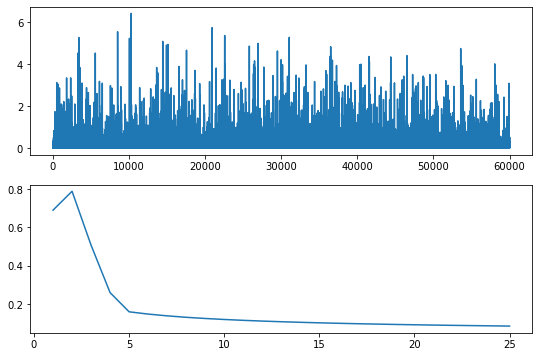

In [50]:
num_samples = data_train.shape[0]
num_dimensions = data_train.shape[1]
weights = th.randn(num_dimensions,1)/783
bias = th.zeros(num_samples,1)
weights.requires_grad_()
bias.requires_grad_()
learning_rate = 10**-5
losses = []
meanLoss = []

num_iterations = 25

print(weights.max())

for i in range(num_iterations):
    weights.requires_grad_()
    bias.requires_grad_()
    loss = 0

    p_hat = logistic_regression(data_train,weights,bias)
    p_hat = p_hat.reshape(target01_train.shape) #VERY IMPORTANT  p_hat needs to be of shape [60000]
    # and not [60000,1] otherweise binary_cross_entropy will return [60000,60000] tensor


    loss = binary_cross_entropy(p_hat, target01_train)
    if(loss.max() == th.inf):
        print('learning rate too high')
        break

    tens = th.ones(loss.shape)
    loss.backward(tens)
    with th.no_grad():
        weights = weights-learning_rate*weights.grad
        bias = bias-learning_rate*bias.grad
    weights.grad = None
    bias.grad = None
    lossi = th.detach(loss)
    losses.append(lossi)
    meanLoss.append(abs(lossi).mean())
    print(weights.max())
    
  
x_axis = np.linspace(1,num_iterations,num_iterations)
fig, axs = plt.subplots(2)

axs[0].plot(losses[-1])
axs[1].plot(x_axis,meanLoss)

print(losses[-1].mean())



___

### <font color='orange'>Question 6</font>

Answer a few questions regarding the training.

1. Every time training starts, the weights are sampled randomly from a Gaussian distribution and therefore the initial behaviour of the logistic regression is random. Run the training procedure a few times and check the initial value of the loss before any parameter update (use `print` or check `losses[0]` after training). Is this value consistent across initializations? What is this value approximately? Can you guess why?
2. What is the minimum possible value for the cross-entropy loss in theory? What is the minimum value you got in practice? Do you think this is a good value for the training loss?
3. What is the best combination of learning rate and number of iterations that you found?
4. What happens to the training loss if you choose a very high learning rate (for example, 100)? Why?


1. initial values mean values of loss: 1.run: 0.6929, 2.run: 0.6925 3.run: 0.6949 4.run: 0.6943 5.run: 0.6953
The inital values of loss seem to be consistent across initalizations. In each initalization the vector weights is created from a standart normal distribion with mean=0 and standard deviation=1, therefore the values are going to be simlar for wach initatlization

2. In theory the minimum loss value would be on average 0, meaning no losses with perfectly fitting weigths.
To quantifiy the loss the mean of the loss vector is taken. 
For losses[-1] the mean values is 0.0815 which seems to be quite good.
I have also saved the mean of loss for every iterations and plotted it against the number of iteraitons.
And in the plot we can see that the loss doesn't get much smaller after about 25 iterations.

3. The minimal loss was of 0.0815 was achieved with a learning rate of 10**-5, a lower learning rate, produced a higher mean loss, propably because it would also need more iteration then. And for higher learning rate, the loss was divergent and therefore no results could be obtained. As mentioned above after 25 iterations the loss doesn't get much smaller, so I would keep the number of iterations at 25. While we could still achieve a bit lower loss with more iterations, the runtime will also be higher.

4. As mentioned above in my model the weigths were already too high, resulting in some values of loss diverging to infinity after the firt iterations. This is because the weights upadte with the gradient can produce some very high weights after the first iterations, probalgy because of locally high gradients. This then causes some very high weights in the second iteration. Thus p_hat will be almost zero because of the negative exponential, making -log(1-p_hat) divergng towards infinity. 



___

### <font color='orange'>Question 7</font>

Save the weight and the bias after training the best model you got. We will use that model in the next section for evaluation.

**INCLUDE THIS FILE IN THE FINAL SUBMISSION FILE** so I can run the evaluation with your model.

In [51]:
# Just run this code
th.save({"weights": weights.detach(), "bias": bias.detach()}, "best_model.pt")

___

## Model evaluation

Evaluation of the model with the test dataset.

First, load the parameters of the model:


In [52]:
model = th.load("best_model.pt")
weights = model["weights"]
bias = model["bias"]

### <font color='orange'>Question 8</font>

Apply the loaded logistic model to the test dataset `data_test` and measure its performance with the labels `target01_test` that you created in Question 2.

1. Plot the ROC curve and the precision-recall curve (make some _nice_ and _decent_ plots with a grid, properly labelled axes...).
2. Compute the area under the ROC curve and the average precision (i.e., the area under the precision-recall curve).
3. Choose a good threshold for the model output and compute the accuracy, sensitivity, specificity, precision, and recall for that threshold.
4. Analyze the results. According to these results, does the model perform well in this problem?

You can use functions from `sklearn.metrics`. Check [the documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics).

area under ROC: 0.9881695673034075 average precision: 0.940091168872847
optimal teshold is: 0.19529608
accuracy= 0.9595 specifity= 0.03904003539040035  sensitivty= 0.9457202505219207
precision = 0.8736951983298539  recall = 0.8736951983298539


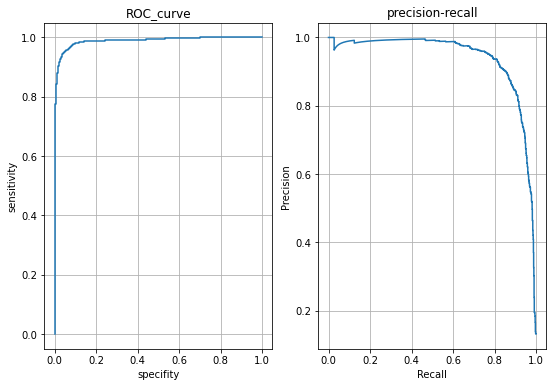

In [53]:
## weights.shape
data_test.shape
bias.shape
predict = logistic_regression(data_test,weights,bias)

from sklearn.metrics import roc_curve

fpr, tpr,tresholds = roc_curve(target01_test,predict) #fpr = false positive, trp = true positive

plt.subplot(1,2,1)
plt.plot(fpr,tpr)
plt.title("ROC_curve")
plt.xlabel("specifity")
plt.ylabel("sensitivity")
plt.grid()

from sklearn.metrics import precision_recall_curve

prec,rec,tresholds2 = precision_recall_curve(target01_test,predict)
plt.subplot(1,2,2)
plt.plot(rec,prec)
plt.title("precision-recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score


ROC_area = roc_auc_score(target01_test,predict)

avg_prec = average_precision_score(target01_test,predict)
print('area under ROC:', ROC_area, 'average precision:', avg_prec)

#chosing good tresholds:
#tresholds were true positive - false positive is maximal
opt_index = np.argmax(tpr-fpr)
opt_treshold = tresholds[opt_index]

opt_index2 = np.argmin(abs(prec-rec))

opt_treshold2 = tresholds2[opt_index2]
print('optimal teshold is:', opt_treshold)

from sklearn.metrics import accuracy_score

predict_tresh = (predict>=opt_treshold).type(th.uint8)
predict_tresh2 = (predict>=opt_treshold).type(th.uint8)

acc = accuracy_score(target01_test,predict_tresh)
acc2 = accuracy_score(target01_test,predict_tresh2)

spec_tresh = fpr[opt_index]
sens_tresh = tpr[opt_index]
prec_tresh = prec[opt_index2]
rec_tresh = rec[opt_index2]

print('accuracy=', acc, 'specifity=',spec_tresh,' sensitivty=',sens_tresh)
print('precision =', prec_tresh, ' recall =', rec_tresh)


# The result seems to be performing quite well as all values are closer to 1 than 0.5. (except for specifity of course)
#the accuracy would is a bit higher for the precision-recall treshold (0.97).
#However both metric (ROC and preicision recall) need to be taken into account to evaluate the model, I chose to take
#the lower value. This means that the accuracy of the model is atleast 0.96
 

___

### <font color='orange'>Question 9</font>

Explore and plot hard cases. Find the samples of the test set that were the most difficult for the model (i.e., high probability of class 1 for samples that are class 0 and vice versa). What are the probabilities that the model predicted for these difficult cases? Plot at least 9 difficult cases from class 0 and 9 difficult cases from class 1.

Explain why you think those cases were hard.

Hint: you can use `torchvision.utils.make_grid` to make plotting easier.

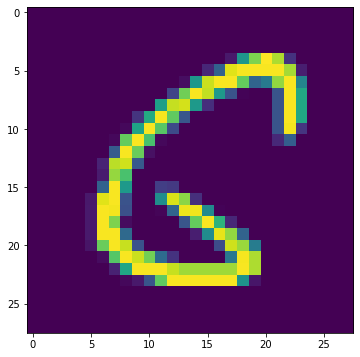

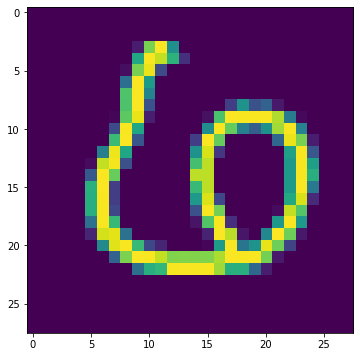

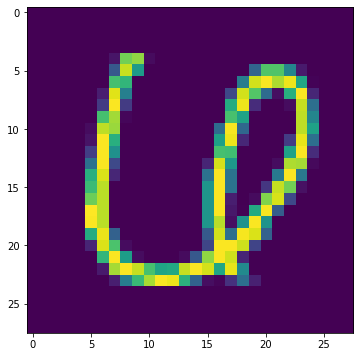

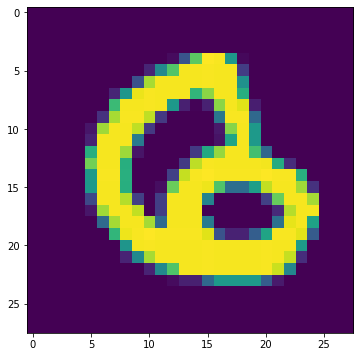

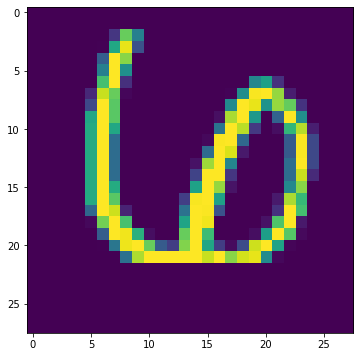

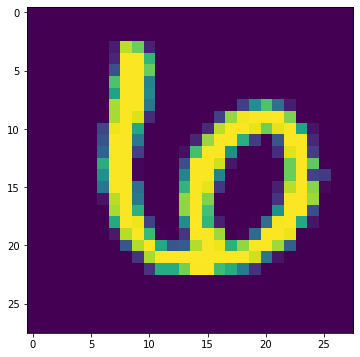

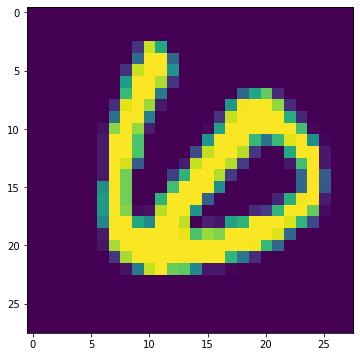

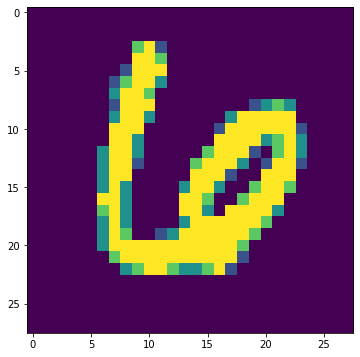

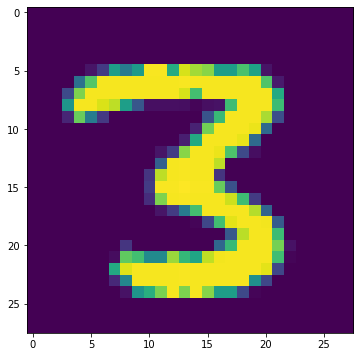

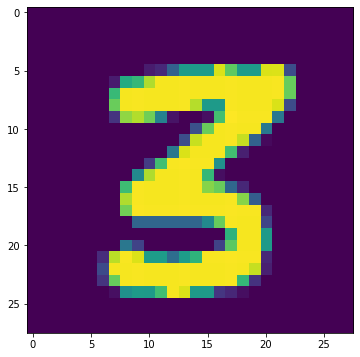

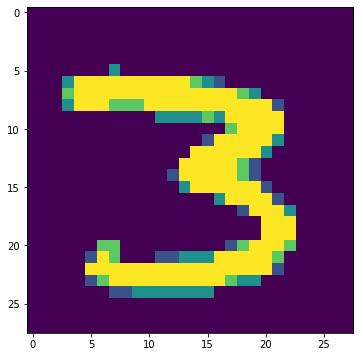

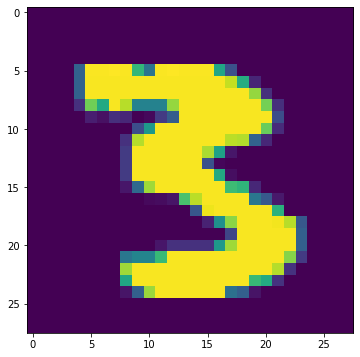

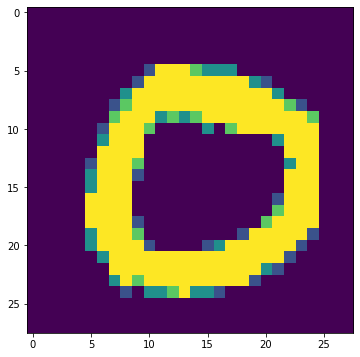

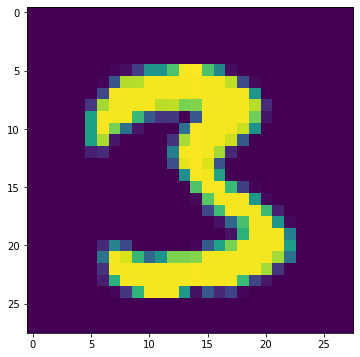

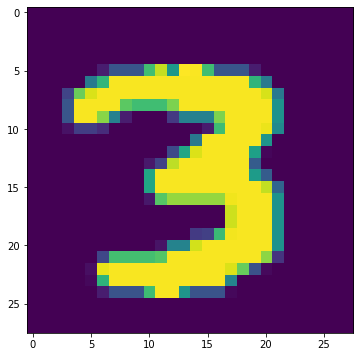

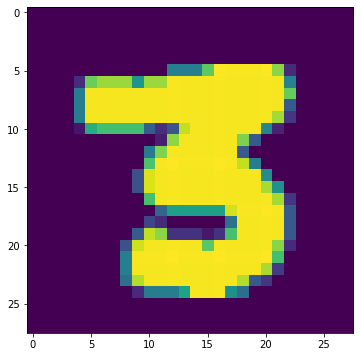

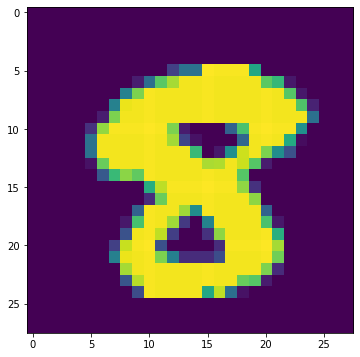

In [54]:
class_indexes = np.where(target01_test==1) #Return tuple of array and nothing
class_indexes = class_indexes[0] #all of class 1 images
class_prob = predict[class_indexes] #all probabilities of class 1 images
worstCase_ind_ind = class_prob.topk(9,dim=0,largest=False)[1] #indexes of the indexes of the worst cases

worstCase_ind = class_indexes[worstCase_ind_ind] #indexes of the worstcases
worstCases = data_test[worstCase_ind,:]

for i in range(9):
    plt.figure(i)
    img = worstCases[i]
    img = img.reshape((28,28))
    plt.imshow(img)
    
    
class_indexes = np.where(target01_test==0) #Return tuple of array and nothing
class_indexes = class_indexes[0] #all of class 1 images
class_prob = predict[class_indexes] #all probabilities of class 1 images
worstCase_ind_ind = class_prob.topk(9,dim=0,largest=False)[1] #indexes of the indexes of the worst cases

worstCase_ind = class_indexes[worstCase_ind_ind] #indexes of the worstcases
worstCases = data_test[worstCase_ind,:]

for i in range(9):
    plt.figure(i+8)
    img = worstCases[i]
    img = img.reshape((28,28))
    plt.imshow(img)
    
    
# For the class1 cases we can clearly see that these are all images where the number is badly written
# it would also be hard for human to recognize the number is some cases

#for the class0 worst cases, the model seems to have problems with the number 3 and images which have a thicker font.




___

### Model analysis

### <font color='orange'>Question 10</font>

Plot the weights of the model as a $28\times{}28$ image with `plt.imshow`. Add a colorbar with `plt.colorbar` to show the range of weights and which weights are positive or negative.

Can you explain this result? Do these weights make sense for the `class1` that you chose?

Hint: think of the effect that an active pixel has on the output of the logistic regression when the weight corresponding to that pixel is positive/negative. 

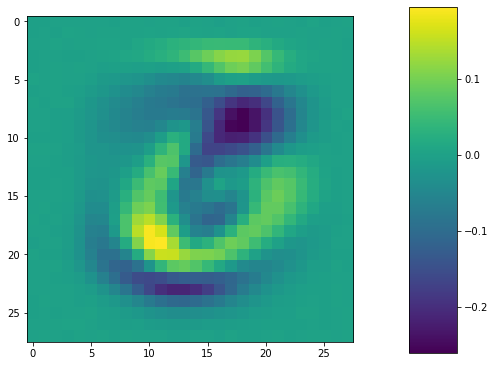

In [55]:
weightplot = weights.reshape((28,28))
plt.imshow(weightplot)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)

#the weights show an image where the large weights resemble the shape of the chosen digit.
#And the low weights are close to the borders of the chosen digit.
#this makes sense because when an acitve pixel matches with the ground truth the gradient will be small.
#Therefore the update will be small and the weights remains higher
#But when a an inactive matches with an active pixel of the ground truth..
#meaning they have the same index in the image vector, the gradient will be very high.
#therefore the wight upadte will result in a much smaller weight.

#The output of the logistic regression function gives the probility that this pixel..
# is correctly set acitve or inactive with respect to the ground truth.
# when a high probability is next to a low probability the gradient will be high
#causing very low weights.

Write your answer here.

___